# Creating a Variational Encoding for the Müller-Brown Potential

In this notebook, we'll be training a Variational Dynamics Encoder (VDE) on a simple case of Brownian dynamics. You'll learn how simple it is to train the VDE on a dataset and visualize the results. We'll also go over using the VDE object to generate synthetic trajectories.

## Imports

Note that this tutorial notebook will require `numpy`, `sklearn`, `msmbuilder`, and `msmexplorer`. Please be sure to install them before running this notebook! To install these dependencies you can run the following in the command-line:

```bash
conda install -yq -c omnia numpy scikit-learn msmbuilder msmexplorer
```

In [1]:
%matplotlib inline

from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool

import numpy as np
from sklearn.pipeline import Pipeline

from msmbuilder.example_datasets import muller, MullerPotential
from msmbuilder.preprocessing import RobustScaler
from msmbuilder.decomposition import tICA, PCA, KernelTICA
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel

import matplotlib.pyplot as pp
import msmexplorer as msme

from vde import VDE # From this package!

/home/cxh/miniconda3/envs/deepchem/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/cxh/miniconda3/envs/deepchem/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/cxh/miniconda3/envs/deepchem/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries modul

## Helper Functions

These are mostly for simulating the Müller-Brown potential and plotting results. 

In [2]:
def simulate(x0s, KT=15000.0, random_state=None):
    M = muller.MULLER_PARAMETERS
    M['KT'] = temp
    random = np.random.RandomState(random_state)
    # propagate releases the GIL, so we can use a thread pool and
    # get a nice speedup
    tp = ThreadPool(cpu_count())
    return tp.map(lambda x0:
        muller.propagate(
            n_steps=M['N_STEPS'], x0=x0, thin=M['THIN'], kT=M['KT'],
            dt=M['DT'], D=M['DIFFUSION_CONST'], random_state=random,
            min_x=M['MIN_X'], max_x=M['MAX_X'], min_y=M['MIN_Y'],
            max_y=M['MAX_Y']), x0s)

def plot_decomp_grid(decomposition, res=100, alpha=1., cmap='magma', ylim=None,
                     obs=0, xlim=None, ax=None, n_levels=3):

    if ax is None:
        _, ax = pp.subplots(1, 1, figsize=(4, 4))
    else:
        if xlim is None:
            xlim = ax.get_xlim()
        if ylim is None:
            ylim = ax.get_ylim()

    if not xlim and not ylim:
        raise ValueError('Please supply x and y limits.')

    X, Y = np.meshgrid(np.linspace(xlim[0], xlim[1], res),
                       np.linspace(ylim[0], ylim[1], res))
    x = np.ravel(X)
    y = np.ravel(Y)
    xy = np.vstack([x, y]).T

    Z = np.vstack(decomposition.transform([xy]))[:, obs].reshape(res, res)

    levels = np.linspace(Z.min(), Z.max(), n_levels + 1)

    cnt = ax.contourf(X, Y, Z, cmap=cmap, alpha=alpha, levels=levels)
    
    for c in cnt.collections:
        c.set_edgecolor("face")
    return ax

def scatter(decomposition, cmap='plasma', stride=10, ax=None):

    if ax is None:
        _, ax = pp.subplots(1, 1, figsize=(4, 4))

    cmap = pp.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs))[::stride].ravel()
    w -= w.min()
    w /= w.max()
    ax.scatter(*np.vstack(trajs)[::stride].T, c=cmap(w))

    return ax

def fit_msm(traj, model=None, lagtime=1, scaled=False):
    if not scaled:
        traj = scaler.transform(traj)
    if model is not None:
        data = model.transform(traj)
    else:
        data = traj
    msm_pipe = Pipeline([('cluster', MiniBatchKMeans(n_clusters=6, batch_size=10000, random_state=256)),
                         ('msm', MarkovStateModel(lag_time=lagtime, verbose=False, n_timescales=3))])

    ass = msm_pipe.fit_transform(data)
    return msm_pipe.steps[-1][1], ass, data

def plot_FE(traj, ax, lagtime=1, model=None, scaled=False):
    msm, ass, data = fit_msm(traj, model=model, lagtime=lagtime, scaled=scaled)
    pi = msm.populations_[np.concatenate(ass)]
    pi /= pi.sum()
    msme.plot_free_energy(np.vstack(data), shade=False,
                          color=cmap(np.linspace(0., 1., 5)[i]), ax=ax, vmax=8,
                          pi=pi)

def plot_FE2D(traj, ax, lagtime=1, cmap='gray', scaled=False):
    msm, ass, data = fit_msm(traj, lagtime=lagtime, scaled=scaled)
    pi = msm.populations_[np.concatenate(ass)]
    pi /= pi.sum()
    msme.plot_free_energy(np.vstack(data), obs=(0, 1), gridsize=50,
                          n_samples=10000, pi=pi, random_state=128, n_levels=5, ax=ax)

def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

## Simulate Brownian Dynamics

We can use the example data from `msmbuilder` to get started and plot the trajectories just to get a sense of what the dataset looks like. Note that we also robust scale the data for improved modeling performance.

In [3]:
trajs_raw = MullerPotential(random_state=128).get().trajectories
scaler = RobustScaler()
trajs = scaler.fit_transform(trajs_raw)

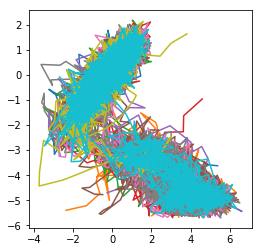

In [4]:
fig, ref_ax = pp.subplots(1, 1, figsize=(4, 4))

for traj in trajs:
    ref_ax.plot(*traj.T)

xlim = ref_ax.get_xlim()
ylim = ref_ax.get_ylim()

## Initializing the Model

Here, we'll be comparing the VDE to both tICA and PCA results. You can see how simple it is to define all three of these models below; although, notice that the VDE has quite a few more user-selectable parameters that you can experiment with. Also note that the VDE is currently set to use a CUDA-enabled device.

In [5]:
lag_time = 10

tica = tICA(n_components=1, lag_time=lag_time)


pca = PCA(n_components=1)


mdl = VDE(trajs[0].shape[-1], lag_time=lag_time,
          hidden_size=256, hidden_layer_depth=3,
          batch_size=250, n_epochs=10, cuda=True, 
          sliding_window=True, dropout_rate=0.3,
          learning_rate=1E-3)

## Fitting the Model

With a single command for each model, we can easily fit them to Müller-Brown dataset.

In [6]:
tica.fit(trajs)

pca.fit(trajs)

mdl.fit(trajs)

Epoch: 0
Batch 100, loss = 1.1403
rec_loss = 1.0877, autocorr_loss = 0.0526
Batch 200, loss = 0.7882
rec_loss = 0.7390, autocorr_loss = 0.0492
Batch 300, loss = 0.7181
rec_loss = 0.6745, autocorr_loss = 0.0436
Epoch: 1
Batch 100, loss = 0.6227
rec_loss = 0.5897, autocorr_loss = 0.0330
Batch 200, loss = 0.7721
rec_loss = 0.7035, autocorr_loss = 0.0686
Batch 300, loss = 0.5867
rec_loss = 0.5492, autocorr_loss = 0.0374
Epoch: 2
Batch 100, loss = 0.4901
rec_loss = 0.4623, autocorr_loss = 0.0278
Batch 200, loss = 0.5261
rec_loss = 0.4920, autocorr_loss = 0.0341
Batch 300, loss = 0.5499
rec_loss = 0.5131, autocorr_loss = 0.0368
Epoch: 3
Batch 100, loss = 0.4709
rec_loss = 0.4417, autocorr_loss = 0.0292
Batch 200, loss = 0.5001
rec_loss = 0.4842, autocorr_loss = 0.0158
Batch 300, loss = 0.5086
rec_loss = 0.4760, autocorr_loss = 0.0326
Epoch: 4
Batch 100, loss = 0.4782
rec_loss = 0.4606, autocorr_loss = 0.0176
Batch 200, loss = 0.5646
rec_loss = 0.5268, autocorr_loss = 0.0379
Batch 300, loss =

## Visualizing the Model

### Scatter Plot

We can first get a rough sense of what is happening by just plotting a subsample of our data and color each point by its corresponding projection value. Notice that the VDE describes the general path an idealized trajectory might take from the bottom-right cluster to the top-left one (purple to yellow), while tICA and PCA are limited to only describing a linear color-gradient corresponding to the slowest linear eigenprocess in the dynamics.

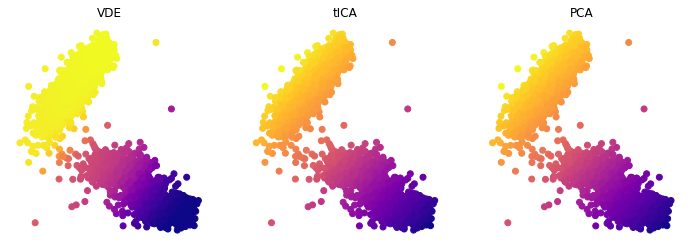

In [7]:
fig, (ax1, ax2, ax3) = pp.subplots(1, 3, figsize=(12, 4))

scatter(mdl, cmap='plasma_r', ax=ax1)
ax1.set_title('VDE')
clean_up(ax1)

scatter(tica, cmap='plasma_r', ax=ax2)
ax2.set_title('tICA')
clean_up(ax2)

scatter(tica, cmap='plasma_r', ax=ax3)
ax3.set_title('PCA')
clean_up(ax3)

### Free Energy Landscape

If we want to get a bit fancier, we can generate a contour map to show exactly how the VDE (and tICA and PCA) transforms phase-space. We'll also plot the two-dimensional free energy landscape estimated from our data as a reference.

Notice that the VDE produces a much richer interpretation of the landscape than either a single tIC or PC can. The major and minor basins are clearly identified by colors at the extrema and values in between follow the trend of the diffusion process. 

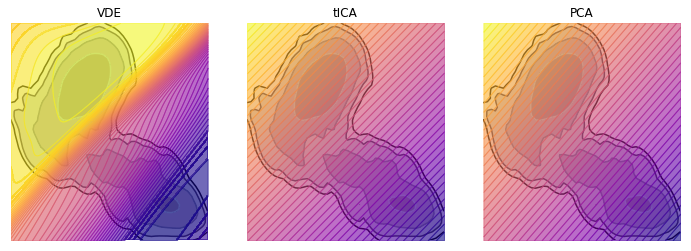

In [8]:
fig, (ax1, ax2, ax3) = pp.subplots(1, 3, figsize=(12, 4))

alpha = 0.6
n_levels = 50

plot_FE2D(trajs, ax1, lagtime=5, scaled=True)
plot_decomp_grid(mdl, n_levels=n_levels, cmap='plasma_r', alpha=alpha, ax=ax1)
ax1.set_title('VDE')
clean_up(ax1)

plot_FE2D(trajs, ax2, lagtime=5, scaled=True)
plot_decomp_grid(tica, n_levels=n_levels, cmap='plasma_r', alpha=alpha, ax=ax2)
ax2.set_title('tICA')
clean_up(ax2)

plot_FE2D(trajs, ax3, lagtime=5, scaled=True)
plot_decomp_grid(pca, n_levels=n_levels, cmap='plasma_r', alpha=alpha, ax=ax3)
ax3.set_title('PCA')
clean_up(ax3)

pp.savefig('muller.pdf')

## Using the Model to Generate Synthetic Trajectories

An interesting property of the VDE is that it is a generative model, which can propagate time-series data. The following cell generates trajectories at varying `scale` values to approximate the effect of changing the simulation temperature.

In [9]:
from torch.autograd import Variable

def propagate(x0, scale, steps=1000):
    traj = [x0]
    for i in range(steps):
        traj.append(mdl.propagate(x0, scale=scale).ravel())
    return np.array(traj)

mdl.eval()

all_temps = np.logspace(-2, -1, 5)
fake_trajs_all = []

for temp in map(float, all_temps):
    print('Temperature set to %s' % temp)
    fake_trajs = []
    for j, traj in enumerate(trajs):
        print('making %s' % j)
        fake_trajs.append(propagate(traj[0], temp))
    fake_trajs_all.append(fake_trajs)

Temperature set to 0.01
making 0
making 1
making 2
making 3
making 4
making 5
making 6
making 7
making 8
making 9
Temperature set to 0.01778279410038923
making 0
making 1
making 2
making 3
making 4
making 5
making 6
making 7
making 8
making 9
Temperature set to 0.03162277660168379
making 0
making 1
making 2
making 3
making 4
making 5
making 6
making 7
making 8
making 9
Temperature set to 0.05623413251903491
making 0
making 1
making 2
making 3
making 4
making 5
making 6
making 7
making 8
making 9
Temperature set to 0.1
making 0
making 1
making 2
making 3
making 4
making 5
making 6
making 7
making 8
making 9


Below, we generate actual Brownian dynamics simulations at different temperatures.

In [10]:
real_trajs_all = []

all_temps = np.logspace(4, 5, 5)
for j, temp in enumerate(all_temps):
    real_trajs_all.append(simulate([traj[0] for traj in trajs_raw], KT=temp, random_state=256))

Here, we plot a one-dimensional free energey landscape (using the VDE latent space) with real data on the left and fake data on the right. Notice that the VDE at certain scaling values, is able to reproduce somewhat realistic thermodynamics; however, its "temperature"-dependence is not quite like that of the true propagator.

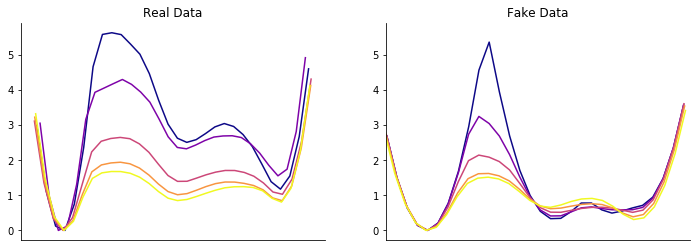

In [11]:
fig, (real_ax, fake_ax) = pp.subplots(1, 2, figsize=(12, 4))

cmap = pp.get_cmap('plasma')    

for i, traj in enumerate(real_trajs_all):
    plot_FE(traj, real_ax, model=mdl, lagtime=10)
    

for i, traj in enumerate(fake_trajs_all):
    plot_FE(traj, fake_ax, model=mdl, scaled=True)   

fake_ax.set_xlim(real_ax.get_xlim())
fake_ax.set_ylim(real_ax.get_ylim())

real_ax.set_xticks([])
fake_ax.set_xticks([])

real_ax.spines["right"].set_visible(False)
real_ax.spines["top"].set_visible(False)
fake_ax.spines["right"].set_visible(False)
fake_ax.spines["top"].set_visible(False)

real_ax.set_title('Real Data')
fake_ax.set_title('Fake Data')

pp.savefig('propagator.pdf')